In [ ]:
 #%conda env update -f env.yml

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/dataset_preparation/2_PredictionDataCreation.ipynb)

In [12]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import os
from pathlib import Path
from random import sample
import shutil
import subprocess

import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import s3fs
from shapely.geometry import box
import rasterio
from rasterio.errors import RasterioIOError

In [13]:
from src.constants import FIRMS_API_KEY, DEFAULT_PARAMS
from src.data_sources import (cluster_fires, 
                              create_chip_bounds, 
                              ndvi_from_topleft, 
                              landcover_from_topleft, 
                              atmospheric_from_topleft, 
                              fires_from_topleft,
                              elevation_from_topleft)

In [ ]:
if not FIRMS_API_KEY:
    raise ValueError('FIRMS_API_KEY empty, please ensure your environment variable set')

# Input parameters

In [15]:
# output_s3 = os.environ['AWS_S3_BUCKET'] + '/predict_test_2'

# North America
bbox= [-168.7,24.8,-51.8,74.2]

# dates to search for fires
begin_date = datetime(2021,12,1)
end_date   = datetime(2021,12,30)

In [16]:

#fs = s3fs.S3FileSystem(key=os.environ['AWS_ACCESS_KEY_ID'], secret=os.environ['AWS_SECRET_ACCESS_KEY'])
print("done")

done


# Load fire data

In [17]:
def load_fires(begin_date, end_date, bbox, day_range=10):
    """
    Given input parameters, search NASA firms API for fires and return GeoDataFrame of fire points
    :param begin_date: datetime
    :param end_date: datetime
    :param bbox: list of floats; left, bottom, right, top
    :param day_range: int for the number of days to search API for
    :return: gpd.GeoDataFrame of fire points
    """
    if day_range > 10:
        # firms api allows max of 10 day range see https://firms.modaps.eosdis.nasa.gov/api/area/
        raise ValueError('"day_range" must be less than or equal to 10')

    start_dates = (pd.date_range(start=begin_date, end=end_date, freq=f"{day_range}D") + pd.Timedelta(f'{day_range}d')).to_pydatetime().tolist()
    if len(start_dates) == 0:
        raise ValueError('No dates to search for, check "begin_date" and "end_date" are formated correctly')
        
    # get min date of the VIIRS_SNPP_NRT so that we can decide based on the date range which FIRMS product(s) we need
    viirs_nrt = pd.read_csv(f'https://firms.modaps.eosdis.nasa.gov/api/data_availability/csv/{FIRMS_API_KEY}/VIIRS_SNPP_NRT')
    viirs_nrt_start = datetime.strptime(viirs_nrt.iloc[0].min_date, '%Y-%m-%d')

    df_fires = pd.DataFrame()
    for start_date in start_dates:
        mapkey_status = requests.get(f'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY={FIRMS_API_KEY}')
        if mapkey_status.json()['current_transactions'] > 460:
            # TODO: tenacity retry wait_exponential:
            raise ValueError('Not enough free transactions left with FIRMS API for given key')

        # split requests by date for VIIRS_SNPP_SP/VIIRS_SNPP_NRT
        if start_date > viirs_nrt_start:
            nrt_request_url = f'https://firms.modaps.eosdis.nasa.gov/api/area/csv/{FIRMS_API_KEY}/VIIRS_SNPP_NRT/{",".join([str(i) for i in bbox])}/{day_range}/{start_date.strftime("%Y-%m-%d")}'
            # df_fires=df_fires.append(pd.read_csv(nrt_request_url),ignore_index=True)
            dfs = [df_fires, pd.read_csv(nrt_request_url)]
            df_fires = pd.concat(dfs, ignore_index=True)



        if (start_date - timedelta(days=day_range)) < viirs_nrt_start:
            sp_request_url = f'https://firms.modaps.eosdis.nasa.gov/api/area/csv/{FIRMS_API_KEY}/VIIRS_SNPP_SP/{",".join([str(i) for i in bbox])}/{day_range}/{start_date.strftime("%Y-%m-%d")}'
            # df_fires=df_fires.append(pd.read_csv(sp_request_url),ignore_index=True)
            dfs = [df_fires, pd.read_csv(sp_request_url)]
            df_fires = pd.concat(dfs, ignore_index=True)

    # drop fires after end_date
    df_fires = df_fires[((df_fires['acq_date'].astype('datetime64[ns]') <= end_date) & (df_fires['acq_date'].astype('datetime64[ns]') >= begin_date))]
    gdf_fires = gpd.GeoDataFrame(df_fires, geometry=gpd.points_from_xy(df_fires.longitude, df_fires.latitude), crs='EPSG:4326')
    return gdf_fires

In [18]:
gdf_fires = load_fires(begin_date, end_date, bbox)
gdf_fires

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry
0,41.61243,-87.32779,318.28,0.41,0.45,2021-12-11,717,N,VIIRS,n,2,284.21,2.49,N,3,POINT (-87.32779 41.61243)
1,41.61656,-87.32710,305.80,0.41,0.45,2021-12-11,717,N,VIIRS,n,2,283.73,1.58,N,3,POINT (-87.3271 41.61656)
2,41.61703,-87.33204,316.36,0.41,0.45,2021-12-11,717,N,VIIRS,n,2,283.63,1.58,N,3,POINT (-87.33204 41.61703)
3,41.62444,-87.14648,300.47,0.40,0.44,2021-12-11,717,N,VIIRS,n,2,283.55,0.73,N,0,POINT (-87.14648 41.62444)
4,41.62857,-87.36546,313.27,0.41,0.45,2021-12-11,717,N,VIIRS,n,2,281.88,1.46,N,3,POINT (-87.36546 41.62857)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,39.97732,-105.18579,342.03,0.72,0.76,2021-12-30,2105,N,VIIRS,n,2,293.50,151.27,D,0,POINT (-105.18579 39.97732)
9770,39.97739,-105.17747,356.84,0.72,0.76,2021-12-30,2105,N,VIIRS,l,2,281.57,151.27,D,0,POINT (-105.17747 39.97739)
9771,39.97745,-105.16907,337.73,0.72,0.76,2021-12-30,2105,N,VIIRS,n,2,277.52,67.61,D,0,POINT (-105.16907 39.97745)
9772,39.98043,-105.17799,343.41,0.72,0.76,2021-12-30,2105,N,VIIRS,n,2,278.63,117.30,D,0,POINT (-105.17799 39.98043)


In [8]:
# create clusters
print('Clustering fires')
df_fire_clustered = cluster_fires(gdf_fires)
df_fire_clustered


Clustering fires


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry,label
3020,35.55244,-101.38100,341.91,0.32,0.55,2021-12-15,1905,N,VIIRS,n,2,292.25,14.45,D,0,POINT (-101.381 35.55244),0
3021,35.55329,-101.37755,367.00,0.32,0.55,2021-12-15,1905,N,VIIRS,h,2,297.19,14.45,D,0,POINT (-101.37755 35.55329),0
3022,35.55416,-101.37403,354.56,0.32,0.55,2021-12-15,1905,N,VIIRS,n,2,299.90,26.07,D,0,POINT (-101.37403 35.55416),0
3023,35.55502,-101.37053,350.15,0.32,0.55,2021-12-15,1905,N,VIIRS,n,2,302.03,26.07,D,0,POINT (-101.37053 35.55502),0
3024,35.55587,-101.36707,349.45,0.32,0.55,2021-12-15,1905,N,VIIRS,n,2,303.05,31.86,D,0,POINT (-101.36707 35.55587),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,36.70002,-101.67110,355.36,0.60,0.70,2021-12-15,2046,N,VIIRS,n,2,283.67,15.64,D,0,POINT (-101.6711 36.70002),2
3396,36.70019,-101.66411,356.29,0.60,0.70,2021-12-15,2046,N,VIIRS,l,2,288.29,15.64,D,0,POINT (-101.66411 36.70019),2
3397,36.70053,-101.65005,356.29,0.60,0.70,2021-12-15,2046,N,VIIRS,l,2,283.67,26.50,D,0,POINT (-101.65005 36.70053),2
3398,36.70246,-101.66301,356.86,0.60,0.70,2021-12-15,2046,N,VIIRS,l,2,283.13,22.33,D,0,POINT (-101.66301 36.70246),2


In [19]:
# create chip bounds
print('Creating chip bounds')
#Path(output_fp).mkdir(parents=True, exist_ok=True)
manifest = create_chip_bounds(df_fire_clustered)
manifest

Creating chip bounds


,idx,left,bottom,right,top,epsg,date
0,0,274125.0,3922875.0,306000.0,3954750.0,32614,2021-12-15
1,1,738000.0,3933375.0,769875.0,3965250.0,32613,2021-12-15
2,2,247500.0,4047750.0,279375.0,4079625.0,32614,2021-12-15
3,3,546750.0,4059750.0,578625.0,4091625.0,32614,2021-12-15


# Process Chips

In [ ]:
def process_chip(chip, fs, output_fp, output_s3, fires,  training=True):
    """
    Given a chips metadata, load all of the training data and write numpy files, finally upload results to S3
    :param chip: records.csv chip to process data for
    :param fs: s3fs.S3FileSystem
    :param output_fp: local directory to write data to
    :param output_s3: local directory to write data to
    :param fires: gpd.GeoDataFrame or path to vector file containing fire point data
    :param cog_footprints: gpd.GeoDataFrame of the dem footprints
    :param training: bool, if true then will load/write next days fires
    """
    print("start processing")
    
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    print("chip read completed")
    if os.path.exists(output_fp + f'/{chip_idx}'):
        return
    
    # check not already on s3
    if len(fs.ls(f'{output_s3}/{chip_idx}')) != 0:
        return
    
    print(f'Processing chip: {chip_idx}')
    
    # create output dir if it doesnt already exist
    output_dir = Path(output_fp).joinpath(str(chip_idx))
    output_dir.mkdir(parents=True, exist_ok=True)


    
    
    # Fetch NDVI data
    try:
        print(f"Fetching NDVI data for chip {chip_idx}")
        ndvi = ndvi_from_topleft([top, left], epsg, chip_date,resolution=375)

        if ndvi is not None:
            np.save(output_dir.joinpath('ndvi.npy'), ndvi)
            print("NDVI data completed")
        else:
            print("No NDVI data available for this chip")
    except Exception as e:
        print(f"Error fetching NDVI data: {e}")    
    
    
    # save bbox to geojson
    bounds_utm = rasterio.coords.BoundingBox(left=left, right=right, bottom=bottom, top=top)
    gpd.GeoSeries([box(*bounds_utm)]).set_crs(epsg).to_file(output_dir.joinpath('bbox.geojson'))
    
    # load fires
    todays_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires)
    np.save(output_dir.joinpath(f'todays_fires.npy'), todays_fires.bool)
    np.save(output_dir.joinpath(f'todays_frp.npy'), todays_fires.frp)
    print("today fire completed")
    
    
    # load fires
    todays_day_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires[fire["daynight"] == "D"')
    np.save(output_dir.joinpath(f'todays_fires.npy'), todays_fires.bool)
    np.save(output_dir.joinpath(f'todays_frp.npy'), todays_fires.frp)
    print("today fire completed") 
    
    
    # load tomorrows fires if training
    
    if training:
        tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
        tomorrows_fires = fires_from_topleft([top, left], epsg, tomorrows_date, fires=fires)
        np.save(output_dir.joinpath(f'tomorrows_fires.npy'), tomorrows_fires.bool)
        np.save(output_dir.joinpath(f'tomorrows_frp.npy'), tomorrows_fires.frp)
    
    # Load today's day fires
    todays_day_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires[fires["daynight"] == "D"])
    np.save(output_dir.joinpath(f'todays_day_fires.npy'), todays_day_fires.bool)
    np.save(output_dir.joinpath(f'todays_day_frp.npy'), todays_day_fires.frp)
    print("Today's day fire data completed")

    # Load today's night fires
    todays_night_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires[fires["daynight"] == "N"])
    np.save(output_dir.joinpath(f'todays_night_fires.npy'), todays_night_fires.bool)
    np.save(output_dir.joinpath(f'todays_night_frp.npy'), todays_night_fires.frp)
    print("Today's night fire data completed")

    # Load tomorrow's fires if training
    if training:
        tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

        # Load tomorrow's day fires
        tomorrows_day_fires = fires_from_topleft([top, left], epsg, tomorrows_date, fires=fires[fires["daynight"] == "D"])
        np.save(output_dir.joinpath(f'tomorrows_day_fires.npy'), tomorrows_day_fires.bool)
        np.save(output_dir.joinpath(f'tomorrows_day_frp.npy'), tomorrows_day_fires.frp)
        print("Tomorrow's day fire data completed")

        # Load tomorrow's night fires
        tomorrows_night_fires = fires_from_topleft([top, left], epsg, tomorrows_date, fires=fires[fires["daynight"] == "N"])
        np.save(output_dir.joinpath(f'tomorrows_night_fires.npy'), tomorrows_night_fires.bool)
        np.save(output_dir.joinpath(f'tomorrows_night_frp.npy'), tomorrows_night_fires.frp)
        print("Tomorrow's night fire data completed")

    # Load elevation data
    try:
        print(f"Fetching elevation data for top_left: {[top, left]}, EPSG: {epsg}")
        dem = elevation_from_topleft([top, left], epsg, resolution=30)
        np.save(output_dir.joinpath('elevation.npy'), dem)
        print("DEM data completed")
    except Exception as e:
        print(f"Error loading DEM data: {e}")
      

    
    # load landcover
    landcover = landcover_from_topleft([top, left], epsg)
    np.save(output_dir.joinpath('landcover.npy'), landcover)
    print("landcover completed")



# Load atmospheric data
    try:
        atmos = atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS, resolution=375)

        # Assuming atmos is a dictionary, process the data based on keys
        for param, data in atmos.items():  # Loop through each key-value pair in the dictionary
            try:
                # Save the data directly
                np.save(output_dir.joinpath(f'{param}.npy'), data)
                print(f"{param} data completed")
            except Exception as e:
                print(f"Error processing parameter {param}: {e}")

    except Exception as e:
        print(f"Error loading atmospheric data: {e}")


    fs.upload(str(output_dir), 
              f'{output_s3}/{chip_idx}/',
             recursive=True)
    shutil.rmtree(output_dir)

In [ ]:
def process_chip_to_local(chip, output_fp, fires, training=True):
    """
    Given a chip's metadata, load all of the training data and write numpy files locally.

    :param chip: records.csv chip to process data for
    :param output_fp: local directory to write data to
    :param fires: gpd.GeoDataFrame or path to vector file containing fire point data
    :param training: bool, if true, then will load/write next day's fires
    """
    print("Start processing")

    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    print("Chip read completed")

    print(f'Processing chip: {chip_idx}')
    
    # Create output dir if it doesn't already exist
    output_dir = Path(output_fp).joinpath(str(chip_idx))
    output_dir.mkdir(parents=True, exist_ok=True)

    # Fetch NDVI data
    try:
        print(f"Fetching NDVI data for chip {chip_idx}")
        ndvi = ndvi_from_topleft([top, left], epsg, chip_date, resolution=375)

        if ndvi is not None:
            np.save(output_dir.joinpath('ndvi.npy'), ndvi)
            print("NDVI data completed")
        else:
            print("No NDVI data available for this chip")
    except Exception as e:
        print(f"Error fetching NDVI data: {e}")

    # Save bounding box to GeoJSON
    bounds_utm = rasterio.coords.BoundingBox(left=left, right=right, bottom=bottom, top=top)
    gpd.GeoSeries([box(*bounds_utm)]).set_crs(epsg).to_file(output_dir.joinpath('bbox.geojson'))
    
    # Load today's day fires
    try:
        todays_day_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires[fires["daynight"] == "D"])
        np.save(output_dir.joinpath(f'todays_day_fires.npy'), todays_day_fires.bool)
        np.save(output_dir.joinpath(f'todays_day_frp.npy'), todays_day_fires.frp)
        print("Today's day fire data completed")
    except Exception as e:
        print(f"Error loading today's day fires: {e}")

    # Load today's night fires
    try:
        todays_night_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires[fires["daynight"] == "N"])
        np.save(output_dir.joinpath(f'todays_night_fires.npy'), todays_night_fires.bool)
        np.save(output_dir.joinpath(f'todays_night_frp.npy'), todays_night_fires.frp)
        print("Today's night fire data completed")
    except Exception as e:
        print(f"Error loading today's night fires: {e}")

    # # Load previous 4 days of fire data
    for i in range(1, 5):
        try:
            previous_date = (datetime.strptime(chip_date, '%Y-%m-%d') - timedelta(days=i)).strftime('%Y-%m-%d')

            # Load previous day's fires
            previous_day_fires = fires_from_topleft([top, left], epsg, previous_date, fires=fires[fires["daynight"] == "D"])
            np.save(output_dir.joinpath(f'previous_day_{i}_fires.npy'), previous_day_fires.bool)
            np.save(output_dir.joinpath(f'previous_day_{i}_frp.npy'), previous_day_fires.frp)

            # Load previous night's fires
            previous_night_fires = fires_from_topleft([top, left], epsg, previous_date, fires=fires[fires["daynight"] == "N"])
            np.save(output_dir.joinpath(f'previous_night_{i}_fires.npy'), previous_night_fires.bool)
            np.save(output_dir.joinpath(f'previous_night_{i}_frp.npy'), previous_night_fires.frp)

            print(f"Previous day {i} fire data completed")
        except Exception as e:
            print(f"Error loading previous day {i} fires: {e}")

    # # Load tomorrow's fires if training
    if training:
        try:
            tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

            # Load tomorrow's day fires
            tomorrows_day_fires = fires_from_topleft([top, left], epsg, tomorrows_date, fires=fires[fires["daynight"] == "D"])
            np.save(output_dir.joinpath(f'tomorrows_day_fires.npy'), tomorrows_day_fires.bool)
            np.save(output_dir.joinpath(f'tomorrows_day_frp.npy'), tomorrows_day_fires.frp)
            print("Tomorrow's day fire data completed")

            # Load tomorrow's night fires
            tomorrows_night_fires = fires_from_topleft([top, left], epsg, tomorrows_date, fires=fires[fires["daynight"] == "N"])
            np.save(output_dir.joinpath(f'tomorrows_night_fires.npy'), tomorrows_night_fires.bool)
            np.save(output_dir.joinpath(f'tomorrows_night_frp.npy'), tomorrows_night_fires.frp)
            print("Tomorrow's night fire data completed")
        except Exception as e:
            print(f"Error loading tomorrow's fires: {e}")



    #Fetch DEM data
    try:
        print(f"Fetching elevation data for top_left: {[top, left]}, EPSG: {epsg}")
        dem = elevation_from_topleft([top, left], epsg, resolution=30)
        np.save(output_dir.joinpath('elevation.npy'), dem)
        print("DEM data completed")
    except Exception as e:
        print(f"Error loading DEM data: {e}")

    # Fetch landcover data
    try:
        landcover = landcover_from_topleft([top, left], epsg, chip_date,resolution = 375) 
        landcover = landcover_from_topleft([top, left], epsg)

        np.save(output_dir.joinpath('landcover.npy'), landcover)
        print("Landcover data completed")
    except Exception as e:
        print(f"Error loading landcover data: {e}")

    # Fetch atmospheric data
    try:
        atmos = atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS, resolution=375)
        #print(f"Atmospheric data returned: {atmos} (type: {type(atmos)})")

        for param, data in atmos.items():  # Loop through each key-value pair in the dictionary
            try:
                np.save(output_dir.joinpath(f'{param}.npy'), data)
                print(f"{param} data completed")
            except Exception as e:
                print(f"Error processing parameter {param}: {e}")
    except Exception as e:
        print(f"Error loading atmospheric data: {e}")

#print(f"Data saved locally at {output_dir}")

output_fp = "/Users/emilychen/Desktop/dataset_preparation/src/data/375"  # Path to save locally
chips = list(manifest.T.to_dict().values())
for chip in chips:
    process_chip_to_local(chip,  output_fp,  gdf_fires,  training=True)

In [ ]:
# if upload to s3
chips = list(manifest.T.to_dict().values())
print(f'Chips total = {len(chips)}')

In [ ]:
# if upload to s3
# query s3 to see which chips already processed and remove from list
processed_chips = fs.ls(output_s3)
processed_chips 

In [ ]:
# if upload to s3
processed_ids = [int(x.split('/')[-1]) for x in processed_chips if x.split('/')[-1].isdigit()]
processed_ids

In [ ]:
## if upload to s3
#  query s3 to see which chips already processed and remove from list
processed_chips = fs.ls(output_s3)
processed_ids = [int(x.split('/')[-1]) for x in processed_chips if x.split('/')[-1].isdigit()]
print(f'Processed = {len(processed_ids)}')
to_process = [x for x in chips if x['idx'] not in processed_ids]
print(f'To process = {len(to_process)}')

In [ ]:
%%time
import math
os.environ['AWS_NO_SIGN_REQUEST'] = 'True'
print("start")

# process chips
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    future_work = [
        executor.submit(process_chip, chip, fs, output_fp, output_s3, gdf_fires,  training=True) for chip in to_process
    ]

# Explore some of the processed chips

Processing Chip ID: 0


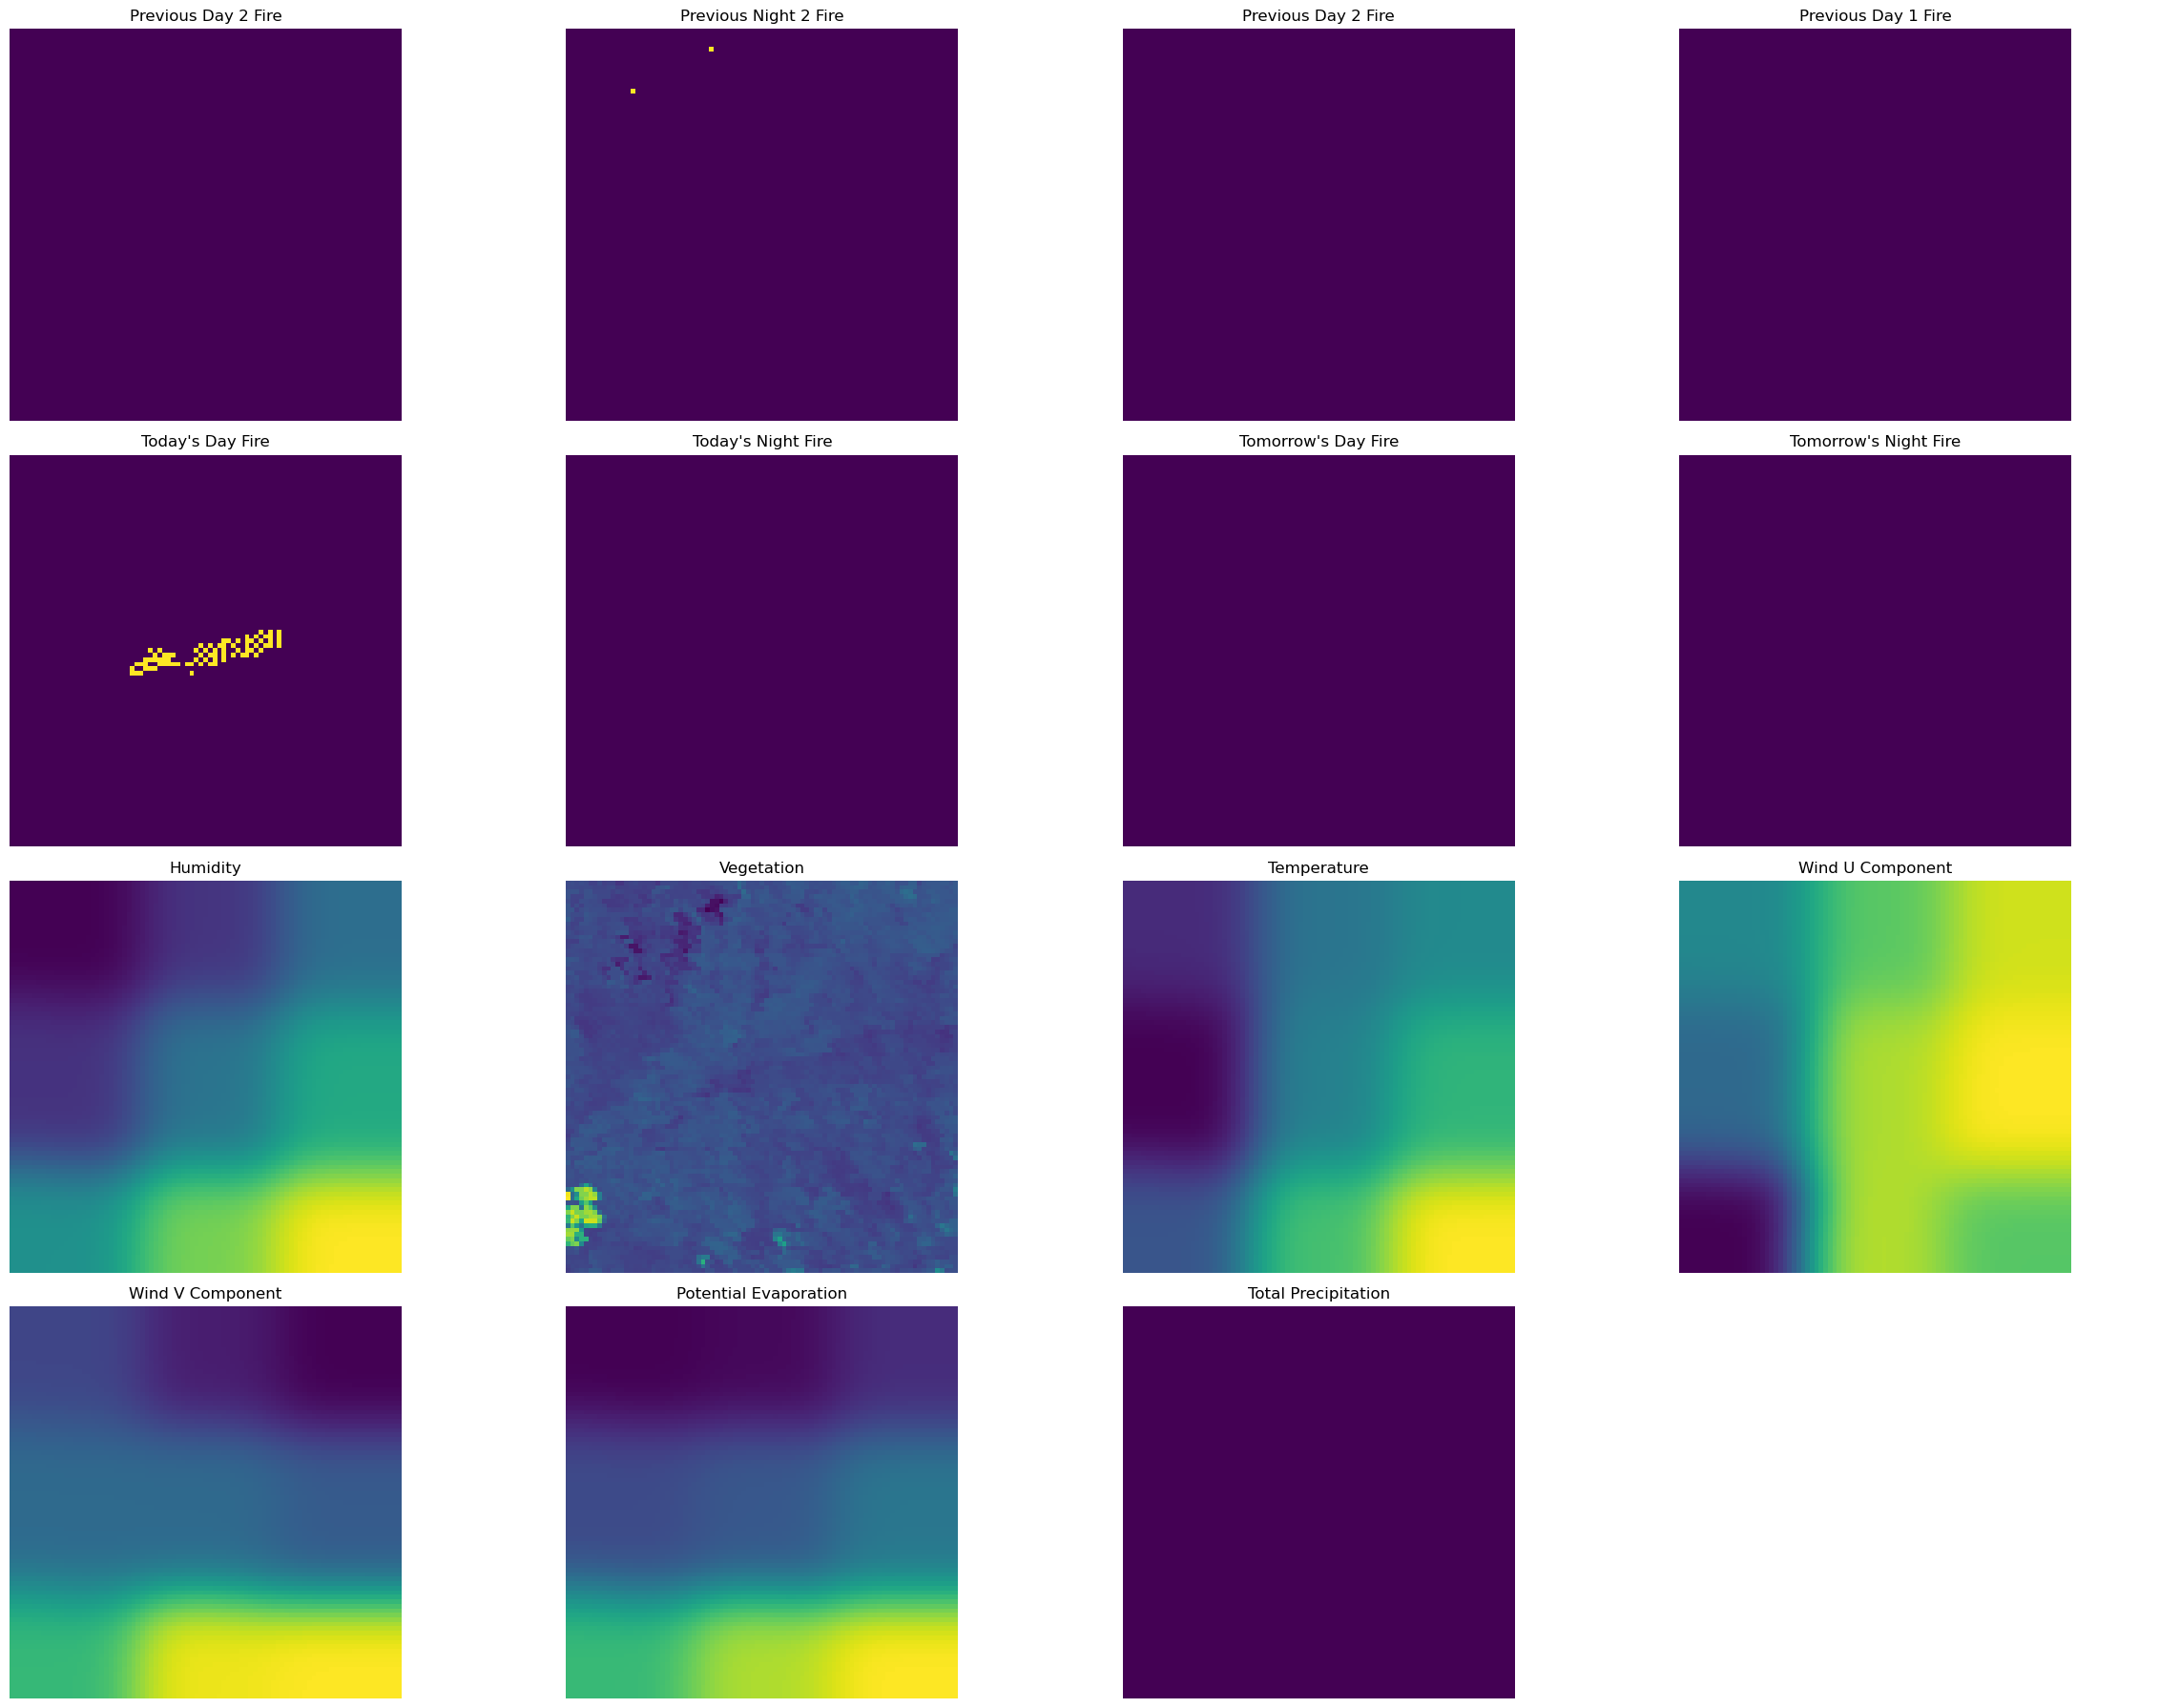

Processing Chip ID: 1


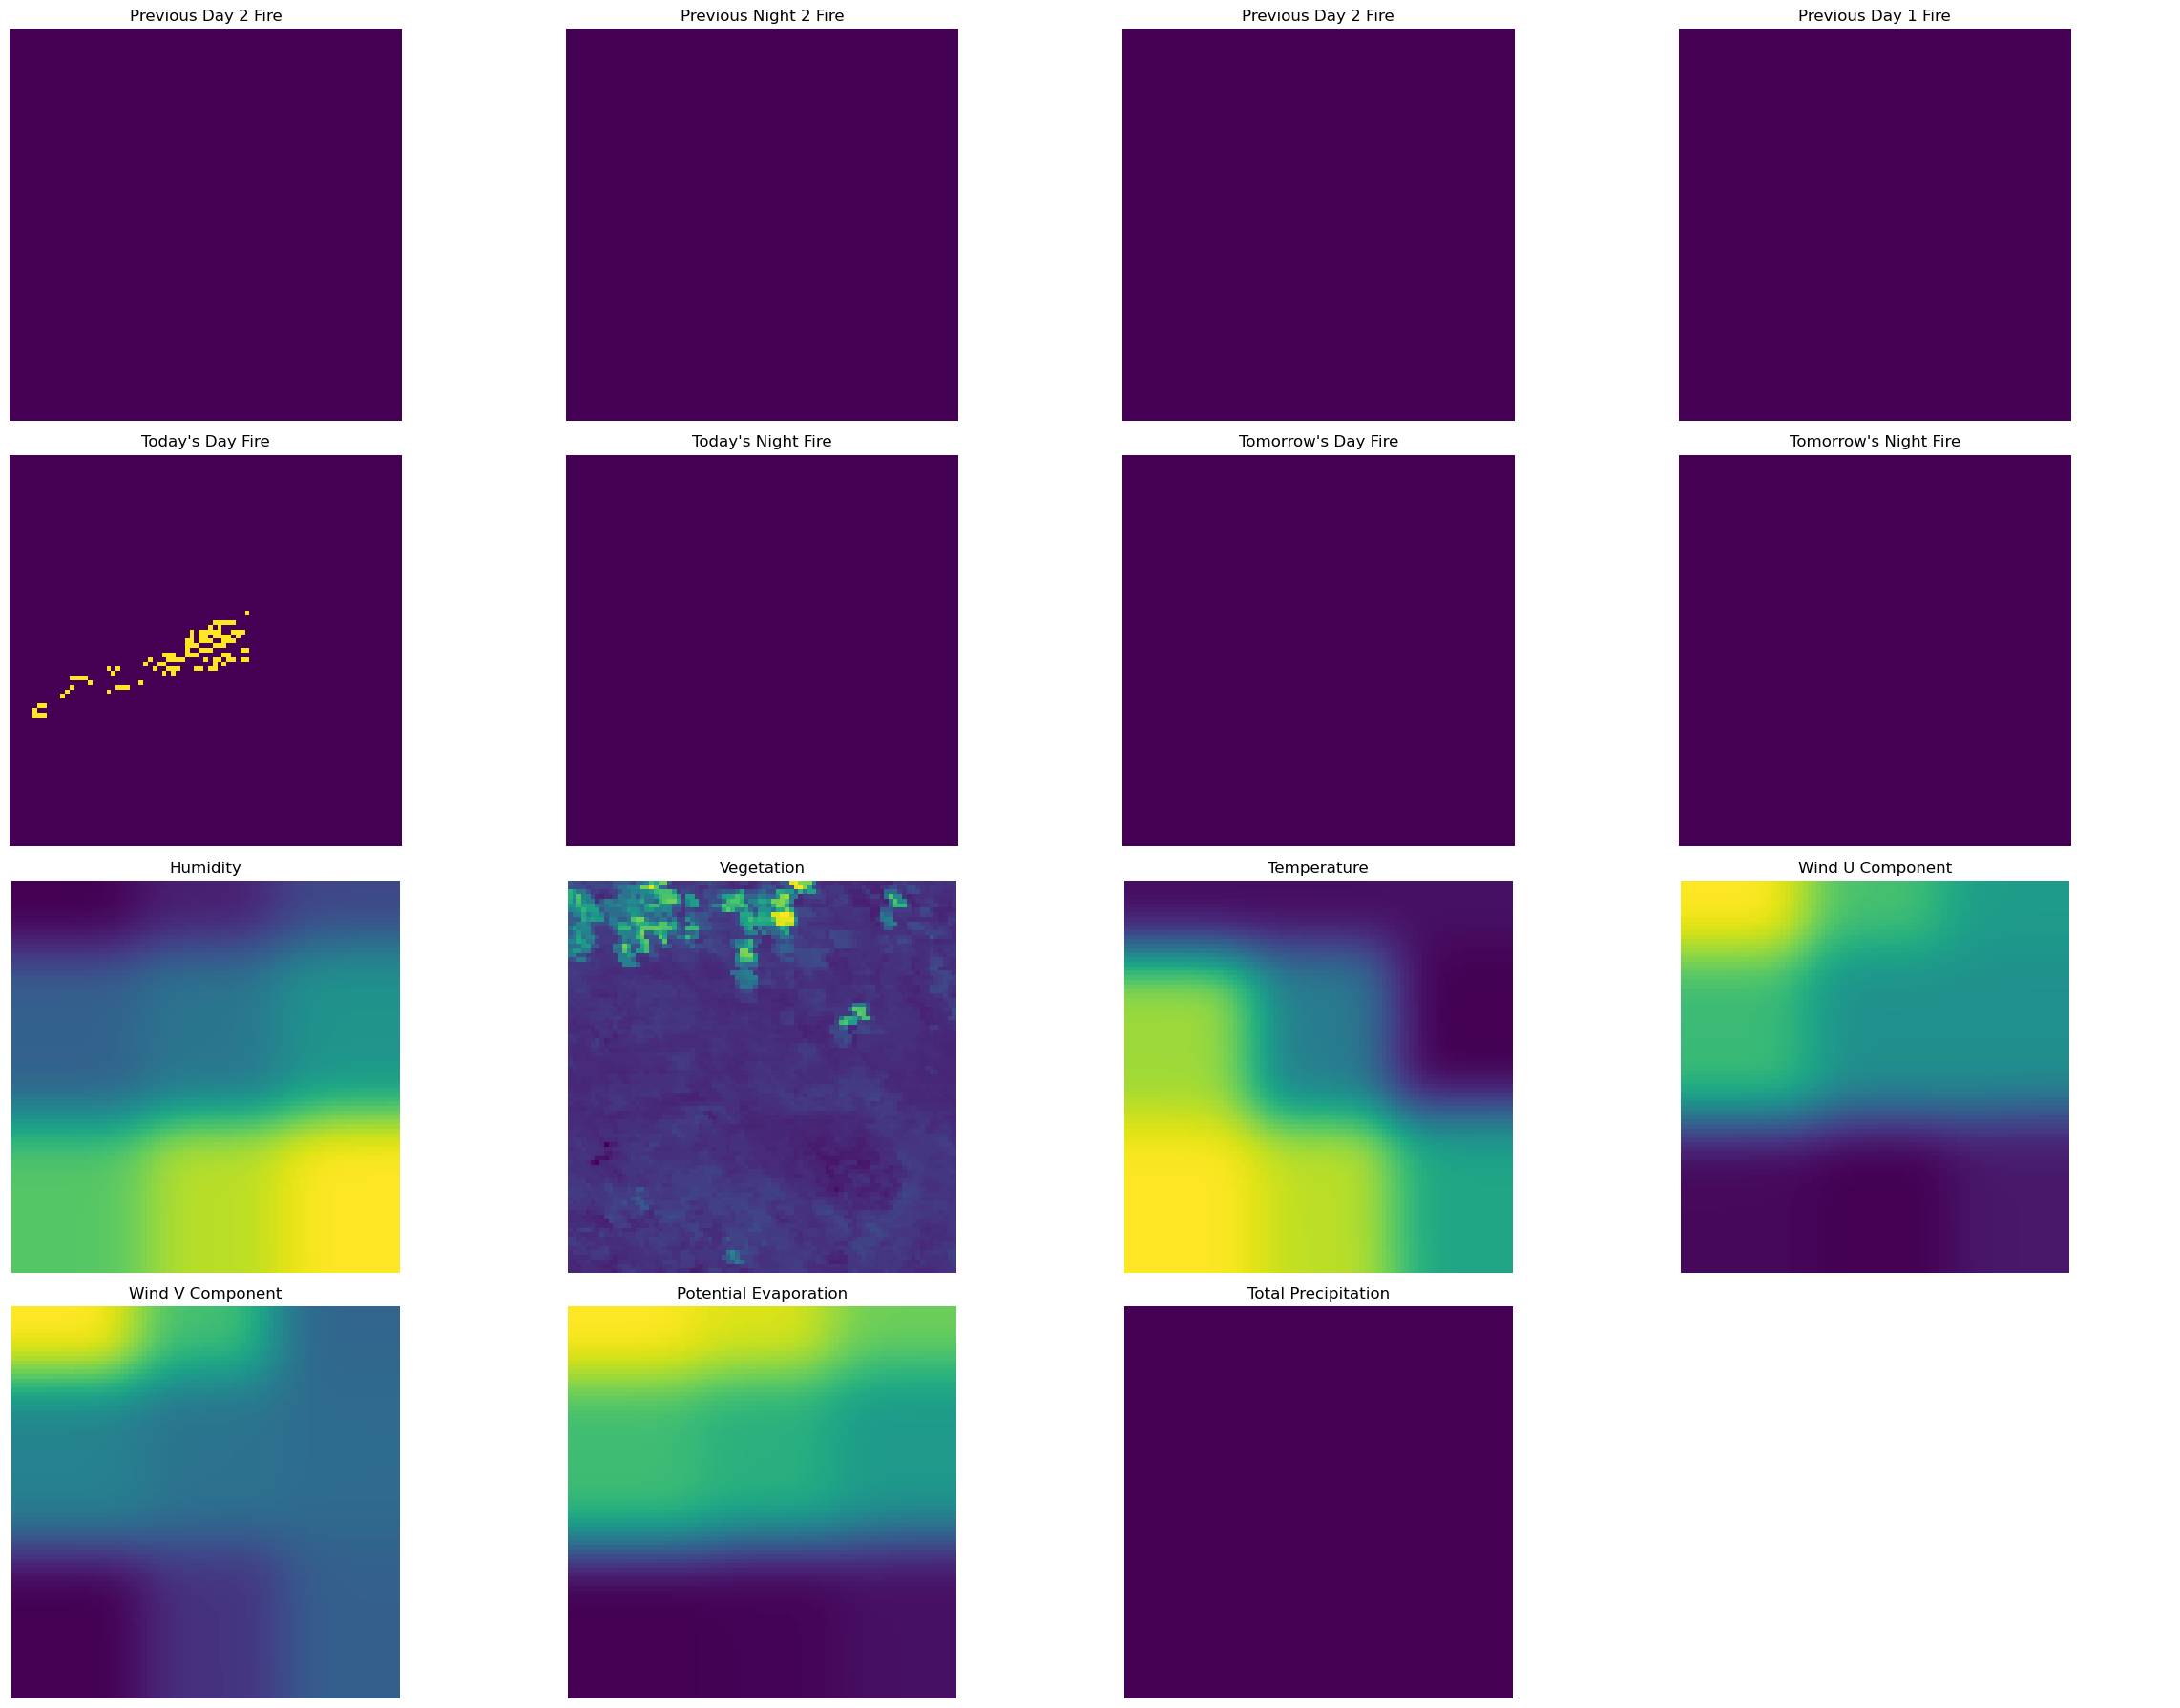

Processing Chip ID: 3


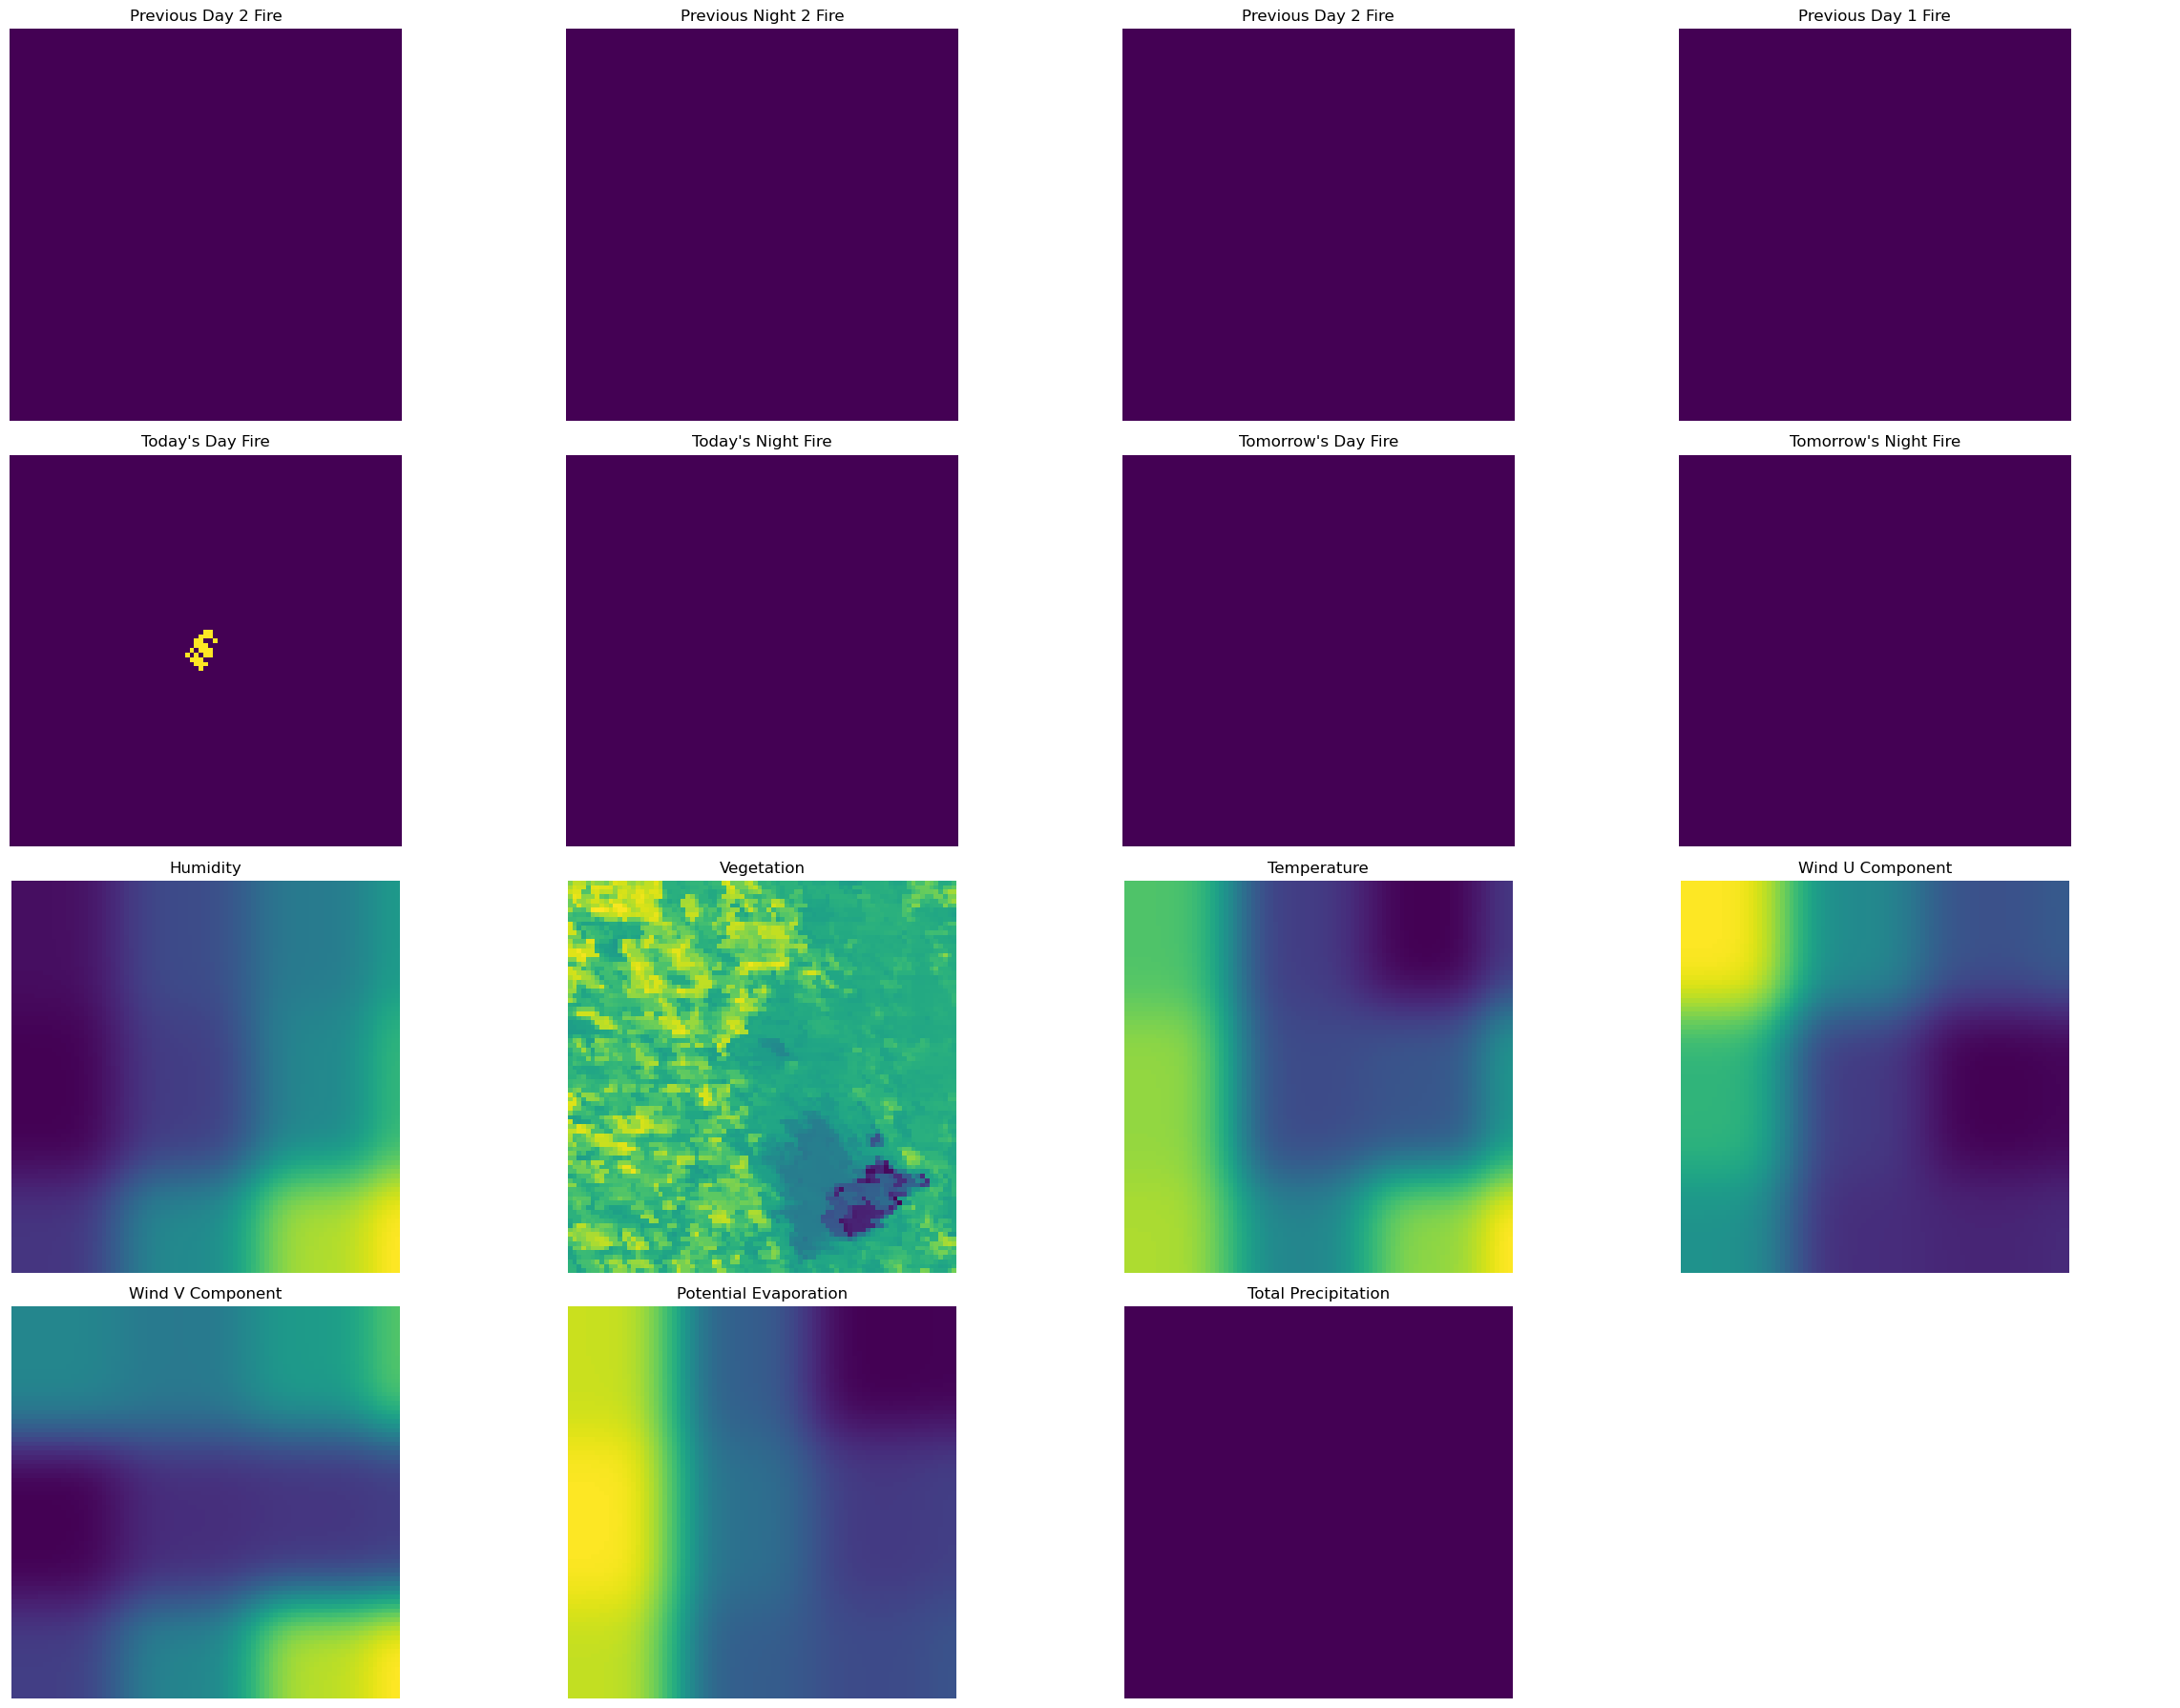

Processing Chip ID: 2


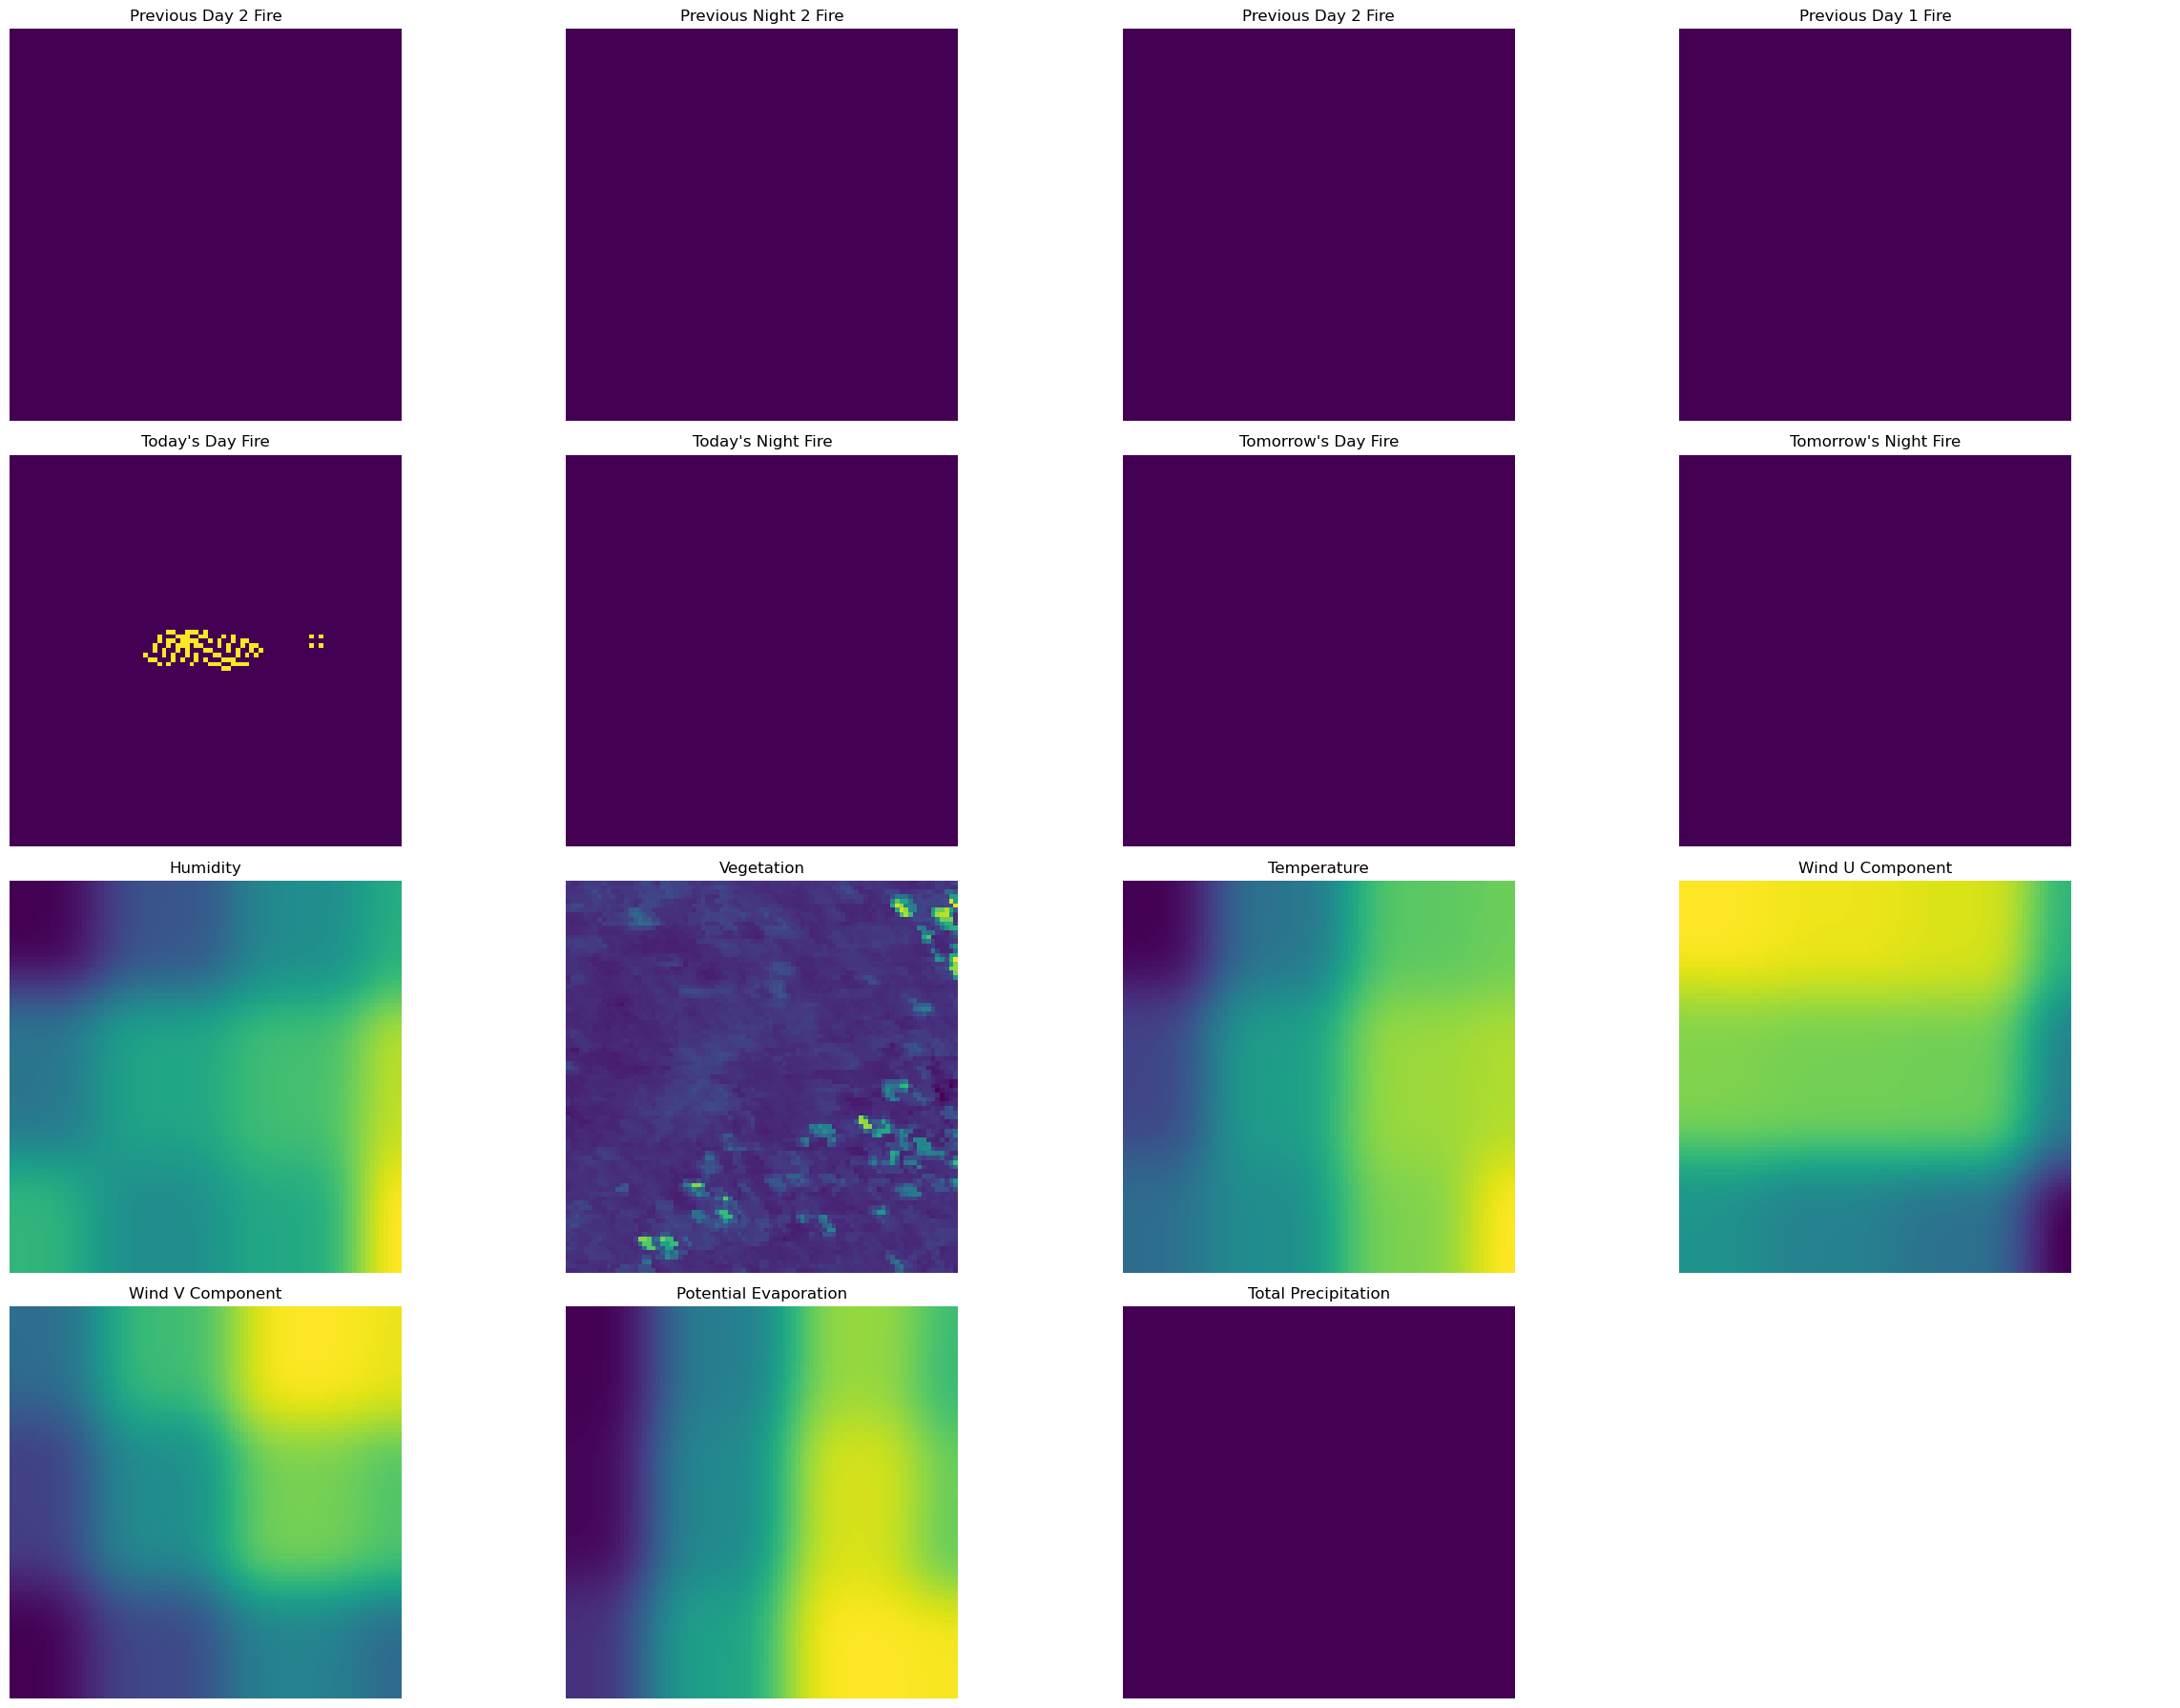

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize

# Set the path to the local directory containing chip data
base_path = "/Users/emilychen/Desktop/dataset_preparation/src/data/375"

# Get all chip folders (assumes folder names are numeric)
chip_folders = [folder for folder in os.listdir(base_path) if folder.isdigit()]

# Iterate over each chip folder
for chip in chip_folders:
    print(f"Processing Chip ID: {chip}")
    
    chip_path = Path(base_path) / chip
    try:
        # Load fire and additional data
        prev_day_2_fire = np.load(chip_path / 'previous_day_2_fires.npy')
        prev_night_2_fire = np.load(chip_path / 'previous_night_2_fires.npy')
        prev_day_1_fire = np.load(chip_path / 'previous_day_1_fires.npy')
        prev_night_1_fire = np.load(chip_path / 'previous_night_1_fires.npy')
        day_fire = np.load(chip_path / 'todays_day_fires.npy')
        night_fire = np.load(chip_path / 'todays_night_fires.npy')
        tmr_day_fire = np.load(chip_path / 'tomorrows_day_fires.npy')
        tmr_night_fire = np.load(chip_path / 'tomorrows_night_fires.npy')
        humidity = np.load(chip_path / 'specific_humidity.npy', allow_pickle=True)
        vegetation = np.load(chip_path / 'ndvi.npy')
        temperature = np.load(chip_path / 'temperature.npy', allow_pickle=True)
        wind_v = np.load(chip_path / 'wind_v.npy', allow_pickle=True)
        wind_u = np.load(chip_path / 'wind_u.npy', allow_pickle=True)
        potential_evaporation = np.load(chip_path / 'potential_evaporation.npy', allow_pickle=True)
        total_precipitation = np.load(chip_path / 'total_precipitation.npy', allow_pickle=True)
    except FileNotFoundError as e:
        print(f"Missing file in chip {chip}: {e}")
        continue

    # Apply Gaussian smoothing for smoother transitions
    def smooth_data(data, sigma=6):
        return gaussian_filter(data, sigma=sigma)

 
    humidity = smooth_data(humidity)
    temperature = smooth_data(temperature)
    wind_v = smooth_data(wind_v)
    wind_u = smooth_data(wind_u)
    potential_evaporation = smooth_data(potential_evaporation)
    total_precipitation = smooth_data(total_precipitation)

    # Create normalization for consistent color scaling
    def normalize_data(data):
        return Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))(data)


    humidity = normalize_data(humidity)
    #vegetation = normalize_data(vegetation)
    temperature = normalize_data(temperature)
    wind_v = normalize_data(wind_v)
    wind_u = normalize_data(wind_u)
    potential_evaporation = normalize_data(potential_evaporation)
    total_precipitation = normalize_data(total_precipitation)

    # Create subplots
    fig, axs = plt.subplots(4, 4, figsize=(24, 18))

    # Plot today's fires (day and night)
    axs[0,0].imshow(prev_day_2_fire, cmap='viridis')
    axs[0,0].set_title("Previous Day 2 Fire")
    axs[0,1].imshow(prev_night_2_fire, cmap='viridis')
    axs[0,1].set_title("Previous Night 2 Fire")
    axs[0,2].set_title("Previous Day 2 Fire")
    axs[0,2].imshow(prev_day_1_fire, cmap='viridis')
    axs[0,3].set_title("Previous Day 1 Fire")
    axs[0,3].imshow(prev_night_1_fire, cmap='viridis')
 

    axs[1, 0].imshow(day_fire, cmap='viridis')
    axs[1, 0].set_title("Today's Day Fire")
    axs[1, 1].imshow(night_fire, cmap='viridis')
    axs[1, 1].set_title("Today's Night Fire")

    # Plot tomorrow's fires (day and night)
    axs[1, 2].imshow(tmr_day_fire, cmap='viridis')
    axs[1, 2].set_title("Tomorrow's Day Fire")
    axs[1, 3].imshow(tmr_night_fire, cmap='viridis')
    axs[1, 3].set_title("Tomorrow's Night Fire")

    # Plot additional data
    axs[2, 0].imshow(humidity, cmap='viridis')
    axs[2, 0].set_title("Humidity")
    axs[2, 1].imshow(vegetation, cmap='viridis')
    axs[2, 1].set_title("Vegetation")
    axs[2, 2].imshow(temperature)
    axs[2, 2].set_title("Temperature")
    axs[2, 3].imshow(wind_u, cmap='viridis')
    axs[2, 3].set_title("Wind U Component")

    # Plot remaining parameters
    axs[3, 0].imshow(wind_v, cmap='viridis')
    axs[3, 0].set_title("Wind V Component")
    axs[3, 1].imshow(potential_evaporation, cmap='viridis')
    axs[3, 1].set_title("Potential Evaporation")
    axs[3, 2].imshow(total_precipitation)
    axs[3, 2].set_title("Total Precipitation")
    
    # Adjust layout and hide empty plots
    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
